In [1]:
import pandas as pd
file_path = r'C:\Users\DanAdams\Documents\Shivkar Project Testing\PUF_TRAUMA.csv'
df = pd.read_csv(file_path)
print(df.columns)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/shivkary/Downloads/CSV/PUF_TRAUMA.csv'

In [ ]:
races = ['AMERICANINDIAN', 'ASIAN', 'BLACK', 'PACIFICISLANDER', 'RACEOTHER', 'WHITE', 'RACE_NA', 'RACE_UK']

# Subset the DataFrame to include only the race columns
df_race = df.loc[:, races]

# Define a function to combine race columns into a single value
def combine_race_columns(row):
    for race in races:
        if row[race] == 1:  # Check if the race column has a value of 1
            return race
    return 'UNKNOWN'  # Default to 'UNKNOWN' if no race column has a value of 1

# Apply the function to create the CombinedRace column
df['CombinedRace'] = df_race.apply(combine_race_columns, axis=1)

# Print the value counts for the CombinedRace column
print(df['CombinedRace'].value_counts())

CombinedRace
WHITE              891737
BLACK              171236
RACEOTHER           99789
ASIAN               29606
RACE_UK             26114
AMERICANINDIAN      11132
PACIFICISLANDER      3342
Name: count, dtype: int64


In [ ]:
# Group by 'CombinedRace' and calculate the required statistics
grouped_df = df.groupby('CombinedRace').agg(
    TotalPatients=('CombinedRace', 'count'),
    MeanAge=('AgeYears', 'mean'),
    MaleCount=('SEX', lambda x: (x == 1).sum()),
    FemaleCount=('SEX', lambda x: (x == 2).sum()),
    NonBinary=('SEX', lambda x: (x == 3).sum()),
    DeathCount=('HOSPDISCHARGEDISPOSITION', lambda x: (x == 5).sum())
)

# Reset the index to make 'CombinedRace' a column instead of the index
grouped_df = grouped_df.reset_index()

# Display the resulting grouped DataFrame
print(grouped_df.head(8))

      CombinedRace  TotalPatients    MeanAge  MaleCount  FemaleCount  \
0   AMERICANINDIAN          11132  41.730083       6896         4162   
1            ASIAN          29606  51.526364      16824        12761   
2            BLACK         171236  39.113151     117834        53246   
3  PACIFICISLANDER           3342  41.827821       2195         1143   
4        RACEOTHER          99789  40.367986      68219        31491   
5          RACE_UK          26114  41.673989      17499         8474   
6            WHITE         891737  55.267067     487256       403521   

   NonBinary  DeathCount  
0          3         273  
1          8         990  
2         50        4186  
3          3          78  
4         40        2235  
5          9        1404  
6        272       24458  


In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import pickle

# Create DeathCount column
df = df.assign(DeathCount=(df['HOSPDISCHARGEDISPOSITION'] == 5).astype(int))

# Handle missing values for other columns
df = df.fillna(df.median(numeric_only=True))  # Fill numeric NaNs with median values

# Encode categorical variables
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le  # Save encoders for potential future use

# Define features (X) and target (y)
X = df.drop(columns=['HOSPDISCHARGEDISPOSITION', 'DeathCount', 'Death'])  # Drop target and irrelevant columns
y = df['DeathCount']

# Compute scale_pos_weight for class imbalance
scale_pos_weight = (len(y) - sum(y)) / sum(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

# Save the trained model to a .pkl file
model_filename = 'xgboost_patient_death_predictor.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved to {model_filename}")

# Save the label encoders (optional, if input variables need encoding on the website)
encoders_filename = 'label_encoders.pkl'
with open(encoders_filename, 'wb') as file:
    pickle.dump(label_encoders, file)

print(f"Encoders saved to {encoders_filename}")


Accuracy: 0.9607245977160654
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    239843
           1       0.40      0.90      0.56      6749

    accuracy                           0.96    246592
   macro avg       0.70      0.93      0.77    246592
weighted avg       0.98      0.96      0.97    246592

ROC-AUC Score: 0.9320734751010661
Model saved to xgboost_patient_death_predictor.pkl
Encoders saved to label_encoders.pkl


In [ ]:
# Check the number of samples used for training
print(f"Number of samples used for training: {X_train.shape[0]}")


Number of samples used for training: 986364


In [ ]:
# Confirm that DeathCount is not in X
print("Features used for training:", list(X.columns))

# Confirm the target variable
print("Target variable name:", y.name)


Features used for training: ['inc_key', 'SEX', 'SEX_BIU', 'AgeYears', 'AMERICANINDIAN', 'ASIAN', 'BLACK', 'PACIFICISLANDER', 'RACEOTHER', 'WHITE', 'RACE_NA', 'RACE_UK', 'ETHNICITY', 'ETHNICITY_BIU', 'WORKRELATED', 'WORKRELATED_BIU', 'PTOCCUPATIONALINDUSTRY', 'PTOCCUPATIONALINDUSTRY_BIU', 'PATIENTSOCCUPATION', 'PATIENTSOCCUPATION_BIU', 'PLACEOFINJURYCODE', 'PLACEOFINJURYCODE_BIU', 'PRIMARYECODEICD10', 'PRIMARYECODEICD10_BIU', 'ADDITIONALECODE1', 'ADDITIONALECODE1_BIU', 'ADDITIONALECODE2', 'ADDITIONALECODE2_BIU', 'PROTDEV_NONE', 'PROTDEV_LAP_BELT', 'PROTDEV_PER_FLOAT', 'PROTDEV_PROTECT_GEAR', 'PROTDEV_EYE_PROTECT', 'PROTDEV_CHILD_RESTRAINT', 'PROTDEV_HELMET', 'PROTDEV_AIRBAG_PRESENT', 'PROTDEV_PROTECT_CLOTH', 'PROTDEV_SHOULDER_BELT', 'PROTDEV_OTHER', 'PROTDEV_NA', 'PROTDEV_UK', 'CHILDSPECIFICRESTRAINT', 'AIRBAG_NOTDEPLOYED', 'AIRBAG_DEPLOYED_FRNT', 'AIRBAG_DEPLOYED_SIDE', 'AIRBAG_DEPLOYED_OTHER', 'AIRBAG_DEPLOYED_NA', 'AIRBAG_DEPLOYED_UK', 'TRANSPORTMODE', 'TRANSPORTMODE_BIU', 'TM_GROUND

In [ ]:
print(y.value_counts())


DeathCount
0    1199332
1      33624
Name: count, dtype: int64


In [ ]:
print("Predictions:", set(y_pred))
print("Class 0 Predictions:", sum(y_pred == 0))
print("Class 1 Predictions:", sum(y_pred == 1))


Predictions: {0, 1}
Class 0 Predictions: 231484
Class 1 Predictions: 15108


Top Features and Their Importance:
WITHDRAWALLST: 28634.873046875
TOTALGCS: 8888.130859375
GCSMOTOR: 4064.3623046875
GCSVERBAL: 2450.959716796875
TOTALVENTDAYS: 1678.268798828125
TBIGCSMOTOR: 1614.54052734375
ISS: 1538.8319091796875
SUPPLEMENTALOXYGEN: 1533.25
TOTALICULOS: 1248.79248046875
PLASMA4HOURS: 947.5932006835938
AgeYears: 899.8138427734375
INPATIENTDAYS: 883.4921875
BLOOD4HOURS: 760.7191772460938
ES_NA: 717.21826171875
PRIMARYMETHODPAYMENT: 679.80517578125
VTEPROPHYLAXISTYPE: 675.4452514648438
EDDISCHARGEDISPOSITION: 570.43115234375
INPATIENTHRS: 552.1576538085938
FINALDISCHARGEDAYS: 475.1302795410156
SEX: 470.7169189453125
TBIHIGHESTTOTALGCS: 461.59765625
ICP_UK: 402.4921875
TM_PRIVPUBVEHWALKIN: 382.1820373535156
TRANSPORTMODE: 365.80474853515625
PMGCSQ_VALID: 361.6543273925781
PLACEOFINJURYCODE: 301.85595703125
FINALDISCHARGEHRS: 290.3558654785156
ADDITIONALECODE1_BIU: 274.2761535644531
PREHOSPITALCARDIACARREST: 265.1386413574219
HIGHESTACTIVATION_BIU: 262.5252685546875
TBIG

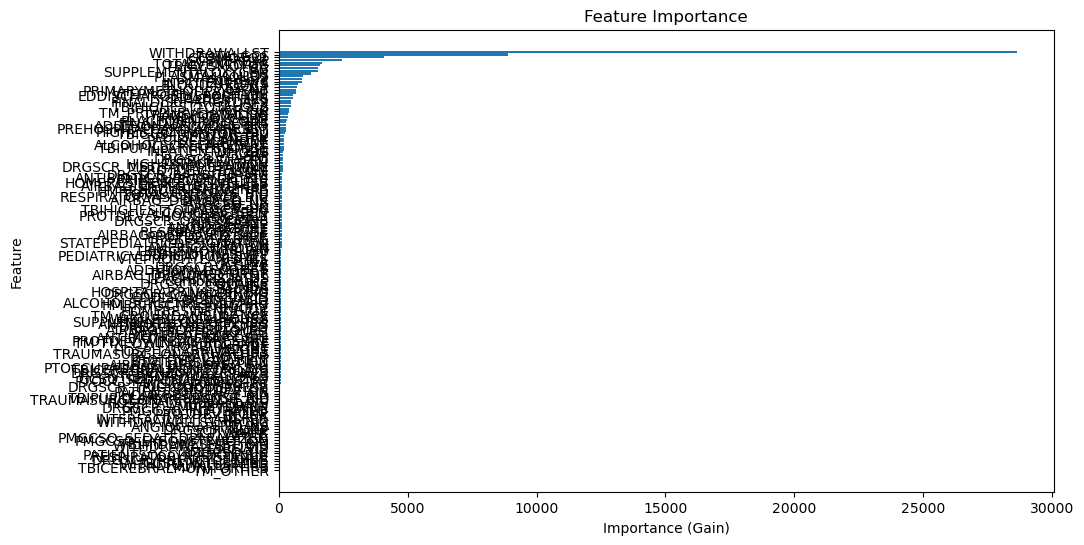

AttributeError: 'NoneType' object has no attribute 'head'

In [ ]:
import matplotlib.pyplot as plt

# Get feature importance scores
importance = model.get_booster().get_score(importance_type='gain')  # 'gain', 'weight', or 'cover'

# Sort the features by importance
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Extract feature names and scores
features = [f[0] for f in importance]
scores = [f[1] for f in importance]

# Display the most important features
print("Top Features and Their Importance:")
for feature, score in zip(features, scores):
    print(f"{feature}: {score}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, scores, align='center')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


Top Features and Their Importance:
WITHDRAWALLST: 28634.873046875
TOTALGCS: 8888.130859375
GCSMOTOR: 4064.3623046875
GCSVERBAL: 2450.959716796875
TOTALVENTDAYS: 1678.268798828125
TBIGCSMOTOR: 1614.54052734375
ISS: 1538.8319091796875
SUPPLEMENTALOXYGEN: 1533.25
TOTALICULOS: 1248.79248046875
PLASMA4HOURS: 947.5932006835938
AgeYears: 899.8138427734375
INPATIENTDAYS: 883.4921875
BLOOD4HOURS: 760.7191772460938
ES_NA: 717.21826171875
PRIMARYMETHODPAYMENT: 679.80517578125


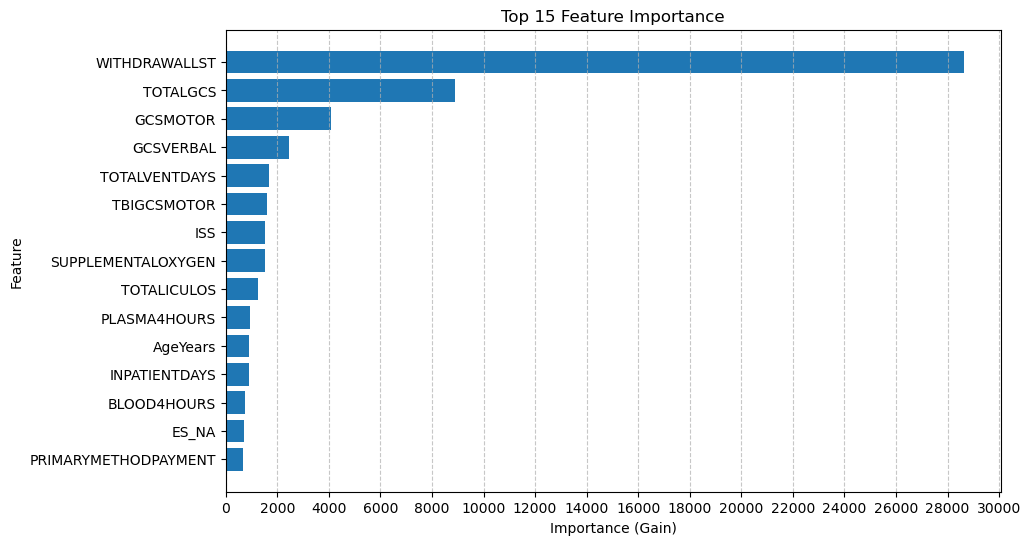

In [ ]:
import matplotlib.pyplot as plt

# Get feature importance scores
importance = model.get_booster().get_score(importance_type='gain')  # 'gain', 'weight', or 'cover'

# Sort the features by importance
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Extract top 10 feature names and scores
top_n = 15  # Adjust this number to show more or fewer features
features = [f[0] for f in importance[:top_n]]
scores = [f[1] for f in importance[:top_n]]

# Display the most important features
print("Top Features and Their Importance:")
for feature, score in zip(features, scores):
    print(f"{feature}: {score}")

# Plot top feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, scores, align='center')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importance')

# Add grid with x-axis ticks every 2000
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(range(0, int(max(scores)) + 2000, 2000))  # Increment ticks by 2000

# Invert y-axis for highest importance at the top
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import os
print("Current Working Directory:", os.getcwd())


Current Working Directory: C:\Users\DanAdams\Documents\Shivkar Project Testing


In [ ]:
import pandas as pd
file_path = r'C:\Users\DanAdams\Documents\Shivkar Project Testing\PUF_TRAUMA.csv'
df = pd.read_csv(file_path)
print(df.columns)

In [ ]:
import pickle
import pandas as pd

# Path to the trained model
model_path = 'xgboost_patient_death_predictor.pkl'  # Update with your actual path

# Step 1: Load the model and extract feature names
def load_model_and_features(model_path):
    # Load the trained model
    with open(model_path, 'rb') as file:
        model = pickle.load(file)

    # Extract feature names from the model
    feature_columns = model.get_booster().feature_names

    return model, feature_columns

# Step 2: Prepare the user input for prediction
def preprocess_input(user_input, feature_columns):
    # Convert user input to a DataFrame
    input_df = pd.DataFrame([user_input], columns=feature_columns)

    # Fill missing columns with default values (e.g., 0)
    for col in feature_columns:
        if col not in input_df.columns:
            input_df[col] = 0

    return input_df

# Step 3: Run inference
def predict(user_input, model, feature_columns):
    # Preprocess the input
    input_df = preprocess_input(user_input, feature_columns)

    # Run prediction
    prediction = model.predict(input_df)

    # Return the result
    return prediction[0]

# Example usage
if __name__ == "__main__":
    # Load model and feature columns
    model, feature_columns = load_model_and_features(model_path)

    # Example user input based on the feature columns
    user_input = {
        'AgeYears': 64,
        'SEX': 1,
        'WHITE': 1,
        'ETHNICITY': 2,
        'WORKRELATED': 2,
        'PTOCCUPATIONALINDUSTRY_BIU': 1,
        'PATIENTSOCCUPATION_BIU': 1,
        'PROTDEV_AIRBAG_PRESENT': 1,
        'AIRBAG_DEPLOYED_SIDE': 1,
        'TRANSPORTMODE': 1,
        'TM_NA': 1,
        'INTERFACILITYTRANSFER': 2,
        'SBP': 87,
        'PULSERATE': 52,
        'TEMPERATURE': 36.7,
        'RESPIRATORYRATE': 20,
        'PULSEOXIMETRY': 95,
        'HEIGHT': 173,
        'PRIMARYMETHODPAYMENT': 3,
        'GCSEYE': 4,
        'GCSVERBAL': 5,
        'GCSMOTOR': 6,
        'TOTALGCS': 15,
        'GCSQ_VALID': 1,
        'DRGSCR_COCAINE': 1,
        'ALCOHOLSCREEN': 2,
        'EDDISCHARGEDISPOSITION': 8,
        'TOTALICULOS_BIU': 9,
        'TOTALGCS': 15,
        'GCSVERBAL': 6

    }

    # Run prediction
    result = predict(user_input, model, feature_columns)

    # Output the result
    print("Prediction:", "Deceased" if result == 1 else "Survived")


Prediction: Survived


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import pickle

# Create DeathCount column
df = df.assign(DeathCount=(df['HOSPDISCHARGEDISPOSITION'] == 5).astype(int))

# Handle missing values for other columns
df = df.fillna(df.median(numeric_only=True))  # Fill numeric NaNs with median values

# Encode categorical variables
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le  # Save encoders for potential future use

# Define features (X) and target (y)
X = df.drop(columns=['HOSPDISCHARGEDISPOSITION', 'DeathCount', 'Death'])  # Drop target and irrelevant columns
y = df['DeathCount']

# Compute scale_pos_weight for class imbalance
scale_pos_weight = (len(y) - sum(y)) / sum(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (Death)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Example of displaying probabilities for predictions
for i, proba in enumerate(y_pred_proba[:10]):  # Show probabilities for the first 10 predictions
    print(f"Sample {i+1}: Probability of Death = {proba:.2%}")

# Save the trained model to a .pkl file
model_filename = 'xgboost_patient_death_predictor_percentage.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved to {model_filename}")

# Save the label encoders (optional, if input variables need encoding on the website)
encoders_filename = 'label_encoders_percentage.pkl'
with open(encoders_filename, 'wb') as file:
    pickle.dump(label_encoders, file)

print(f"Encoders saved to {encoders_filename}")


Accuracy: 0.9607245977160654
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    239843
           1       0.40      0.90      0.56      6749

    accuracy                           0.96    246592
   macro avg       0.70      0.93      0.77    246592
weighted avg       0.98      0.96      0.97    246592

ROC-AUC Score: 0.9835437997761621
Sample 1: Probability of Death = 0.00%
Sample 2: Probability of Death = 0.08%
Sample 3: Probability of Death = 0.21%
Sample 4: Probability of Death = 13.26%
Sample 5: Probability of Death = 9.84%
Sample 6: Probability of Death = 0.00%
Sample 7: Probability of Death = 7.48%
Sample 8: Probability of Death = 49.43%
Sample 9: Probability of Death = 0.38%
Sample 10: Probability of Death = 68.47%
Model saved to xgboost_patient_death_predictor_percentage.pkl
Encoders saved to label_encoders_percentage.pkl


In [ ]:
import pickle
import pandas as pd

# Path to the trained model
model_path = 'xgboost_patient_death_predictor_percentage.pkl'  # Update with your actual path

# Step 1: Load the model and extract feature names
def load_model_and_features(model_path):
    # Load the trained model
    with open(model_path, 'rb') as file:
        model = pickle.load(file)

    # Extract feature names from the model
    feature_columns = model.get_booster().feature_names

    return model, feature_columns

# Step 2: Prepare the user input for prediction
def preprocess_input(user_input, feature_columns):
    # Convert user input to a DataFrame
    input_df = pd.DataFrame([user_input], columns=feature_columns)

    # Fill missing columns with default values (e.g., 0)
    for col in feature_columns:
        if col not in input_df.columns:
            input_df[col] = 0

    return input_df

# Step 3: Run inference
def predict_percentage(user_input, model, feature_columns):
    # Preprocess the input
    input_df = preprocess_input(user_input, feature_columns)

    # Run prediction to get probabilities
    prediction_proba = model.predict_proba(input_df)

    # Extract the probability of the positive class (death)
    probability_of_death = prediction_proba[0][1]  # Class 1 (Death)

    # Convert to percentage
    return probability_of_death * 100

# Example usage
if __name__ == "__main__":
    # Load model and feature columns
    model, feature_columns = load_model_and_features(model_path)

    # Example user input based on the feature columns
    user_input = {
        'AgeYears': 64,
        'SEX': 1,
        'WHITE': 1,
        'ETHNICITY': 2,
        'WORKRELATED': 2,
        'PTOCCUPATIONALINDUSTRY_BIU': 1,
        'PATIENTSOCCUPATION_BIU': 1,
        'PROTDEV_AIRBAG_PRESENT': 1,
        'AIRBAG_DEPLOYED_SIDE': 1,
        'TRANSPORTMODE': 1,
        'TM_NA': 1,
        'INTERFACILITYTRANSFER': 2,
        'SBP': 87,
        'PULSERATE': 52,
        'TEMPERATURE': 36.7,
        'RESPIRATORYRATE': 20,
        'PULSEOXIMETRY': 95,
        'HEIGHT': 173,
        'PRIMARYMETHODPAYMENT': 3,
        'GCSEYE': 4,
        'GCSVERBAL': 5,
        'GCSMOTOR': 6,
        'TOTALGCS': 15,
        'GCSQ_VALID': 1,
        'DRGSCR_COCAINE': 1,
        'ALCOHOLSCREEN': 2,
        'EDDISCHARGEDISPOSITION': 8,
        'TOTALICULOS_BIU': 9,
        'TOTALGCS': 15,
        'GCSVERBAL': 6
    }

    # Run prediction
    death_chance_percentage = predict_percentage(user_input, model, feature_columns)

    # Output the result
    print(f"Prediction: {death_chance_percentage:.2f}% chance of death")


Prediction: 25.67% chance of death
